# Semantic segmentation UNet

## Introduction
Image segmentation is the process of classifying each pixel in an image belonging to a certain class and hence can be thought of as a classification problem per pixel. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset used is the ADE20K Dataset which contains more than 20K scene-centric images exhaustively annotated with objects and object parts. Specifically, the dataset is divided into 20K images for training, 2K images for validation, and another batch of held-out images for testing. There are totally 150 semantic categories included for evaluation, which include stuffs like sky, road, grass, and discrete objects like person, car, bed. The type of data we are going to manipulate consist in:

*   RGB jpg images
*   1 channel jpg masks where each pixel has a value from 0 to 150 defining its class
*   150 possible classes + 1 undefined

## Environment

In [ ]:
from glob import glob
import shutil
import argparse
import zipfile
import hashlib
import requests
from tqdm import tqdm
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime, os
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Tensorflow ver. {tf.__version__}")

## Download the dataset

In [ ]:
def check_sha1(filename, sha1_hash):
    """Check whether the sha1 hash of the file content matches the expected hash.
    Parameters
    ----------
    filename : str
        Path to the file.
    sha1_hash : str
        Expected sha1 hash in hexadecimal digits.
    Returns
    -------
    bool
        Whether the file content matches the expected hash.
    """
    sha1 = hashlib.sha1()
    with open(filename, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)

    sha1_file = sha1.hexdigest()
    l = min(len(sha1_file), len(sha1_hash))
    return sha1.hexdigest()[0:l] == sha1_hash[0:l]

def download(url, path=None, overwrite=False, sha1_hash=None):
    """Download an given URL
    Parameters
    ----------
    url : str
        URL to download
    path : str, optional
        Destination path to store downloaded file. By default stores to the
        current directory with same name as in url.
    overwrite : bool, optional
        Whether to overwrite destination file if already exists.
    sha1_hash : str, optional
        Expected sha1 hash in hexadecimal digits. Will ignore existing file when hash is specified
        but doesn't match.
    Returns
    -------
    str
        The file path of the downloaded file.
    """
    if path is None:
        fname = url.split('/')[-1]
    else:
        path = os.path.expanduser(path)
        if os.path.isdir(path):
            fname = os.path.join(path, url.split('/')[-1])
        else:
            fname = path

    if overwrite or not os.path.exists(fname) or (sha1_hash and not check_sha1(fname, sha1_hash)):
        dirname = os.path.dirname(os.path.abspath(os.path.expanduser(fname)))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        print('Downloading %s from %s...'%(fname, url))
        r = requests.get(url, stream=True)
        if r.status_code != 200:
            raise RuntimeError("Failed downloading url %s"%url)
        total_length = r.headers.get('content-length')
        with open(fname, 'wb') as f:
            if total_length is None: # no content length header
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk: # filter out keep-alive new chunks
                        f.write(chunk)
            else:
                total_length = int(total_length)
                for chunk in tqdm(r.iter_content(chunk_size=1024),
                                  total=int(total_length / 1024. + 0.5),
                                  unit='KB', unit_scale=False, dynamic_ncols=True):
                    f.write(chunk)

        if sha1_hash and not check_sha1(fname, sha1_hash):
            raise UserWarning('File {} is downloaded but the content hash does not match. ' \
                              'The repo may be outdated or download may be incomplete. ' \
                              'If the "repo_url" is overridden, consider switching to ' \
                              'the default repo.'.format(fname))

    return fname

def download_ade(path, overwrite=False):

    """Download ADE20K
    Parameters
    ----------
    path : str
      Location of the downloaded files.
    overwrite : bool, optional
      Whether to overwrite destination file if already exists.
    """
    if not os.path.exists(path):
        os.mkdir(path)
    _AUG_DOWNLOAD_URLS = [
      ('http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip', '219e1696abb36c8ba3a3afe7fb2f4b4606a897c7'),
      ('http://data.csail.mit.edu/places/ADEchallenge/release_test.zip', 'e05747892219d10e9243933371a497e905a4860c'),]
    download_dir = os.path.join(path, 'downloads')
    if not os.path.exists(download_dir):
        os.mkdir(download_dir)
    for url, checksum in _AUG_DOWNLOAD_URLS:
        filename = download(url, path=download_dir, overwrite=overwrite, sha1_hash=checksum)
        # extract
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall(path=path)

In [ ]:
# if downloading dataset

root = "/content/"
dataset_path = root + "ADEChallengeData2016/images/"
training_data = "training/"
val_data = "validation/"

download_ade(root, overwrite=False)

## Dataloader

In [ ]:
IMG_SIZE = 128
# RGB (3 channels)
N_CHANNELS = 3
# 150 classes + undefined
N_CLASSES = 151

### Creating a source dataset

In [ ]:
TRAINSET_SIZE = len(glob(dataset_path + training_data + "*.jpg"))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(dataset_path + val_data + "*.jpg"))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

The Training Dataset contains 20210 images.
The Validation Dataset contains 2000 images.


In [ ]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Image path:
    # .../trainset/images/training/ADE_train_00000001.jpg
    # Annotation path:
    # .../trainset/annotations/training/ADE_train_00000001.png
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess up with our N_CLASS = 150
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself

    return {'image': image, 'segmentation_mask': mask}

In [ ]:
SEED = 42

In [ ]:
train_dataset = tf.data.Dataset.list_files(dataset_path + training_data + "*.jpg", seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(dataset_path + val_data + "*.jpg", seed=SEED)
val_dataset =val_dataset.map(parse_image)

### Dataset transformations
The following code performs a simple augmentation of flipping an image. In addition, image is normalized to [0,1].

In [ ]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

The dataset already contains the required splits of test and train and so let's continue to use the same split.

In [ ]:
BATCH_SIZE = 5
BUFFER_SIZE = 1000

dataset = {"train": train_dataset, "val": val_dataset}

# -- Train Dataset --#
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)

#-- Validation Dataset --#
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


Let's take a look at an image example and it's correponding mask from the dataset.

In [ ]:
def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

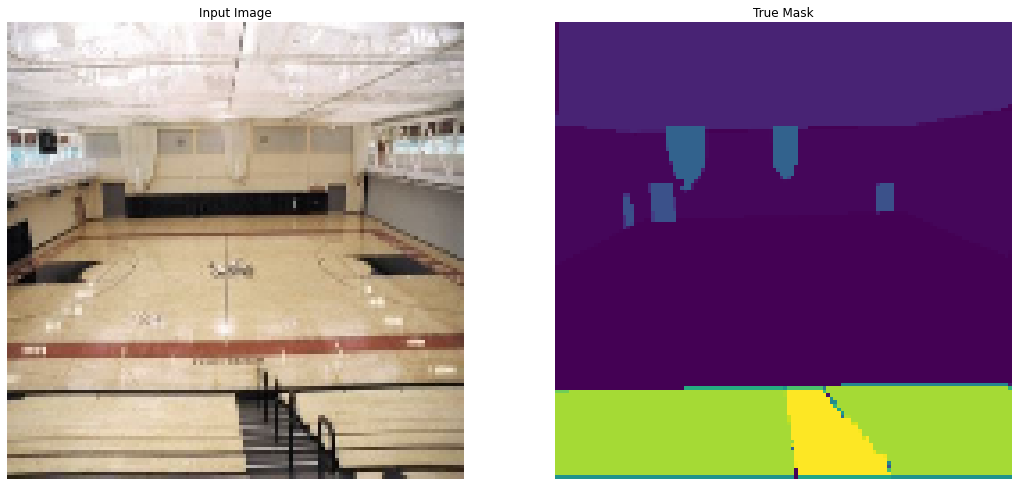

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

display_sample([sample_image[0], sample_mask[0]])

## Define the model
The model being used here is a modified UNet. A UNet consists of an encoder (downsampler) and decoder (upsampler). UNet has an encoder-decoder type of structure. The encoder takes in the image, performs various convolutions and max-pooling operations on the image and builds a latent representation of it. Now, the decoder takes this representation and upsamples the image ( with the help of skip connections ), finally giving us the segmentation mask.

This model does not use a pre-trained model, but one built from scratch.

![figure 1](https://yann-leguilly.gitlab.io/img/unet_1/figure_1.png)

In [ ]:
dropout_rate = 0.5
input_size = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# about initializers:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb

# When initializing weights in a neural net, two problems can arise following activation functions:
# - activation explosion when initializing leads to weights that are too big (activations go to nan)
# - vanishing activation when initializing leads to weights that are too smalll (activations go to 0)

# He initialization works better for layers with ReLu activation
# Xavier initialization works better for layers with sigmoid activation
# ReLu surpassed sigmoid activation as it allowed to solve vanishing / exploding gradients problem

initializer = 'he_normal'

# initial image size: 128 x 128 x 3
# [(W−K+2P)/S]+1

# W is the input volume - 128
# K is the Kernel size - 3
# P is the padding - 'same' => 1
# S is the stride - default 1

# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)
# [(128-3+2*1)/1+1] -> 128 => output shape (128,128,64)

# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
# output shape (64,64,64)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)
# output shape (64,64,128)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
# output shape (32,32,128)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)
# output shape (32,32,256)

# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
# output shape (16,16,256)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)
# output shape (16,16,512)
# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
# output shape (8,8,512)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# output shape (8,8,1024)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
# output shape (16,16,512)
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
# output shape (16,16,1024)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)
# output shape (16,16,512)

# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
# output shape (32,32,256)
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
# output shape (32,32,512)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)
# output shape (32,32,256)

# Block decoder 3
# output shape (64,64,128)
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
# output shape (64,64,256)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)
# output shape (64,64,128)

# Block decoder 4
# output shape (128,128,64)
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
# output shape (128,128,128)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# output shape (128,128,64)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
# output shape (128,128,2)
# -- Decoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)
# output shape (128,128,N_CLASSES)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy()`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0...150}. The network here is outputting 151 channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy()` is the recommended loss for 
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
model = tf.keras.Model(inputs = inputs, outputs = output)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

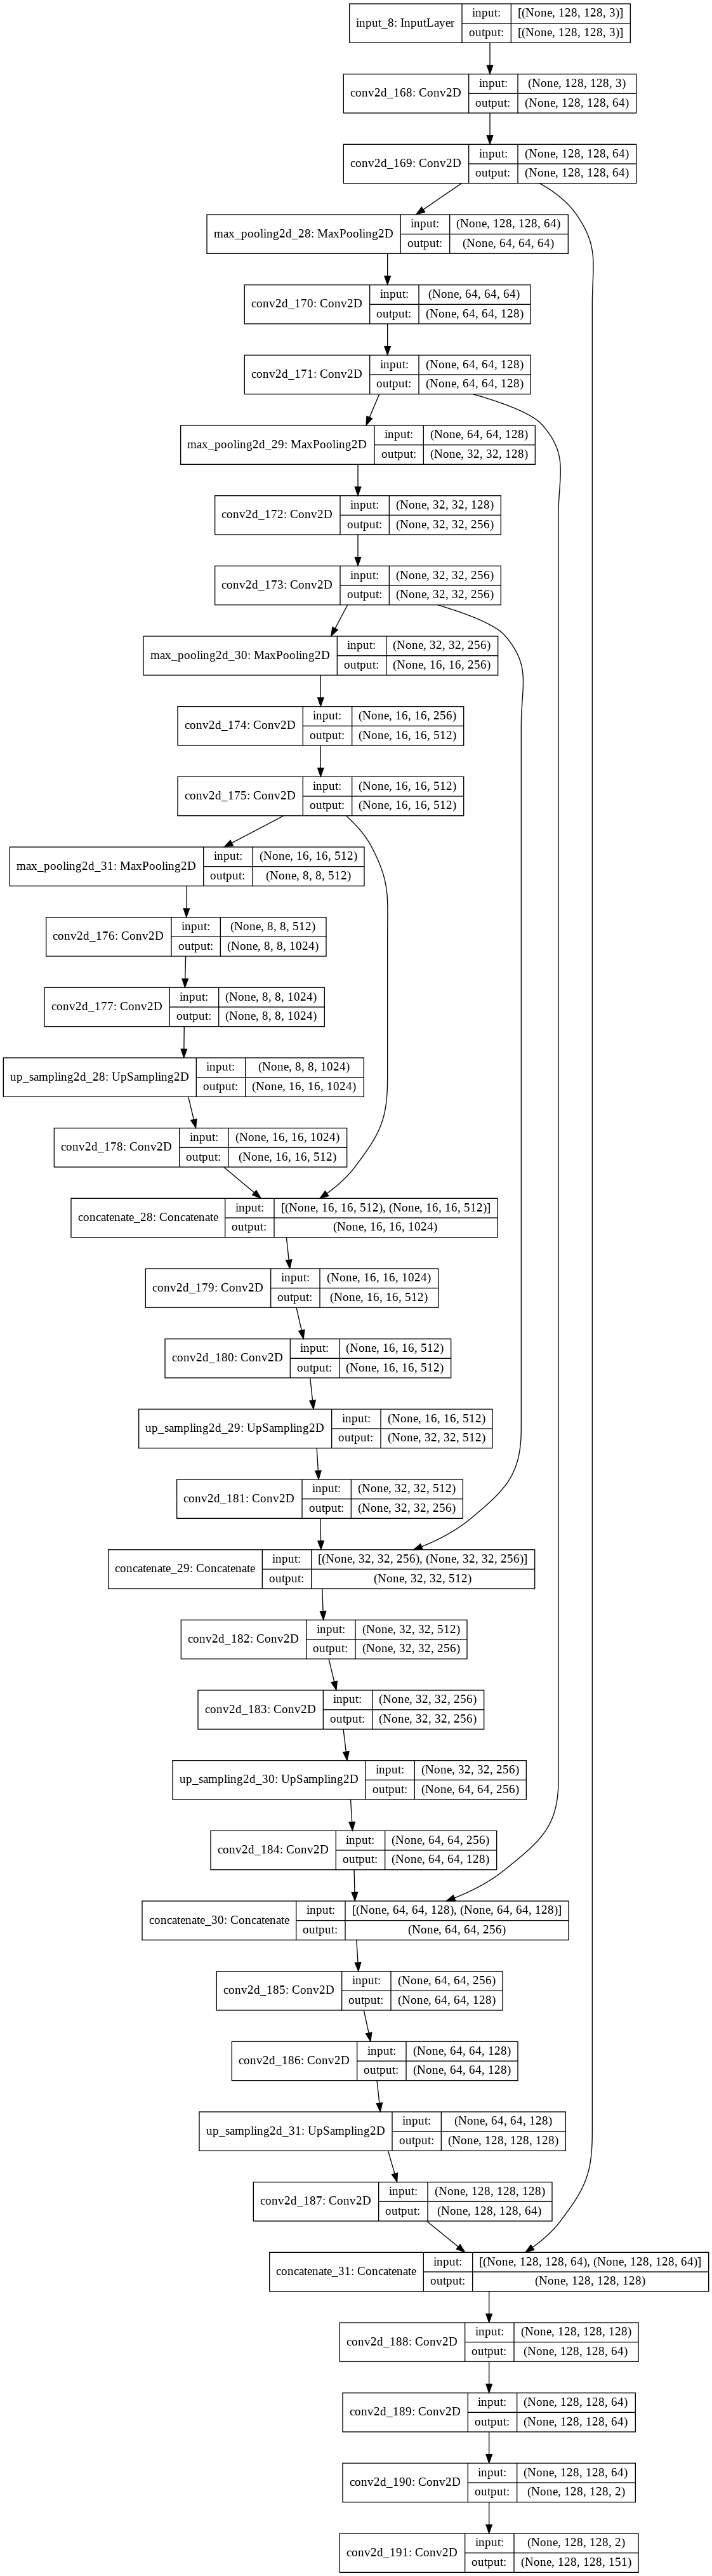

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class but we want the highest score only
    # so we use argmax
    pred_mask = tf.argmax(pred_mask, axis=-1)
    # pred_mask becomes [IMG_SIZE, IMG_SIZE]
    # but matplotlib needs [IMG_SIZE, IMG_SIZE, 1]
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask
    
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            one_img_batch = image[0][tf.newaxis, ...]
            inference = model.predict(one_img_batch)
            pred_mask = create_mask(inference)
            display_sample([image[0], mask[0], pred_mask[0]])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0], pred_mask[0]])

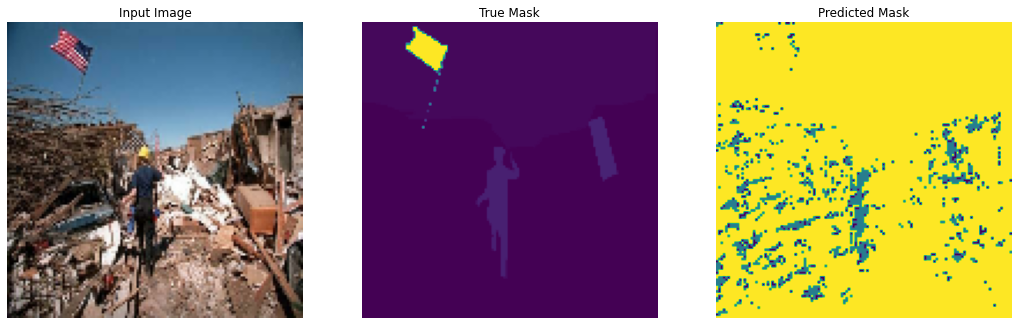

In [ ]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below. 

## Simple training loop

In [ ]:
EPOCHS = 1

STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

In [ ]:
model_history = model.fit(dataset['train'], epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=dataset['val'])

4042/4042 [==============================] - 529s 130ms/step - loss: 4.0376 - accuracy: 0.1396 - val_loss: 3.1237 - val_accuracy: 0.2508


## Training loop

Callbacks will be used to show the output of the model compared to the original image and the ground truth after each epochs. Tensorboard will also be used to monitor training.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model = tf.keras.Model(inputs = inputs, outputs = output)

optimizer=tfa.optimizers.RectifiedAdam(lr=1e-3)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [ ]:
EPOCHS = 20

model.compile(optimizer=optimizer, loss = loss,
                  metrics=['accuracy'])

model_history = model.fit(dataset['train'], epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=dataset['val'],
                    callbacks=callbacks)

Output hidden; open in https://colab.research.google.com to view.

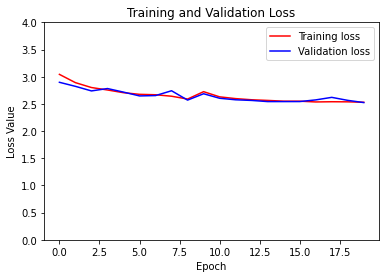

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 4])
plt.legend()
plt.show()

## Make predictions

Show some predictions on the validation dataset to see result after training for 20 epochs.

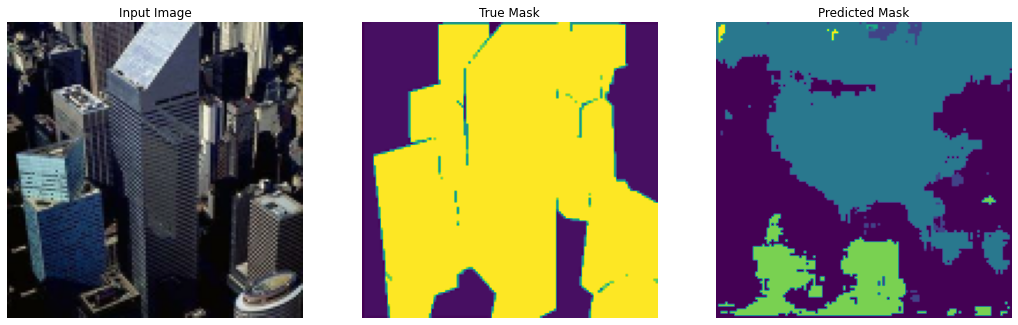

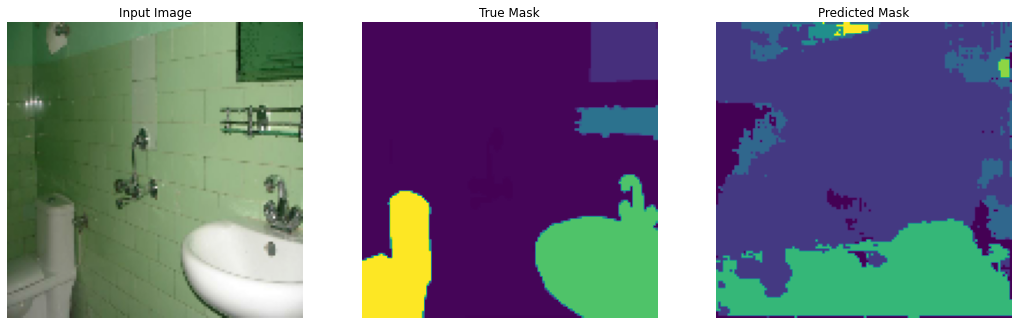

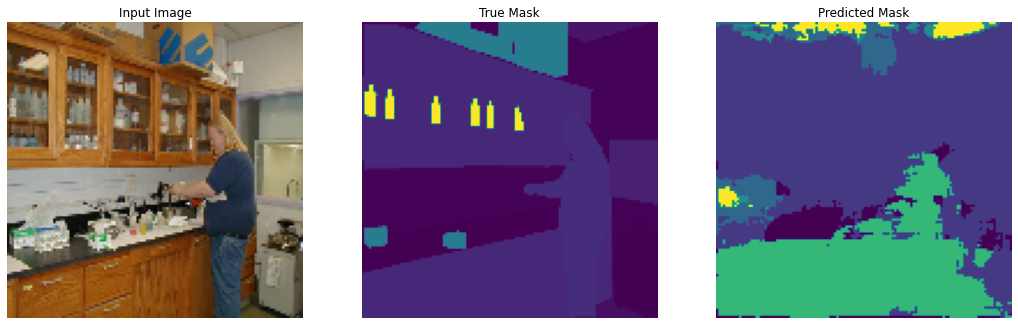

In [ ]:
show_predictions(dataset['val'], 3)